## Diverse Dermatology Images Dataset

DDI dataset for skin cancer lesion classification.

Diverse Dermatology Images (DDI) dataset—the first publicly available, deeply curated, and pathologically confirmed image dataset with diverse skin tones.

Dataset link:
https://stanfordaimi.azurewebsites.net/datasets/35866158-8196-48d8-87bf-50dca81df965
Dataset access request is required. 

- For research purpose only!

*** There are 656 images representing 570 unique patients. Each image label was expertly curated: skin tone was labeled based on in-person evaluation at the clinic visit cross-referenced against demographic photos and review of the clinical images by two board certified dermatologists. Each diagnosis was based on pathology reports from biopsy: these reports and the corresponding image was reviewed by a board certified dermatologist and dermatopathologist.***

In [24]:
import os
import sys
import glob

import numpy as np
import pandas as pd
from scipy import stats
from scipy import ndimage
import skimage.io

import torch
import torch.nn as nn
import timm
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torchvision
from torchvision import models, transforms
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models import MobileNet_V2_Weights
from torch.utils.data import WeightedRandomSampler
from torchvision.models import (VGG16_Weights, ResNet50_Weights, Inception_V3_Weights,
                                inception_v3, mobilenet_v2, MobileNet_V2_Weights)
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

from PIL import Image
import cv2 as cv
import copy 
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
%matplotlib inline

In [2]:
ddi_df = pd.read_csv('ddi_metadata.csv',index_col=0)
ddi_df.head()

,DDI_ID,DDI_file,skin_tone,malignant,disease
0,1,000001.png,56,True,melanoma-in-situ
1,2,000002.png,56,True,melanoma-in-situ
2,3,000003.png,56,True,mycosis-fungoides
3,4,000004.png,56,True,squamous-cell-carcinoma-in-situ
4,5,000005.png,12,True,basal-cell-carcinoma


In [3]:
ddi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 656 entries, 0 to 655
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   DDI_ID     656 non-null    int64 
 1   DDI_file   656 non-null    object
 2   skin_tone  656 non-null    int64 
 3   malignant  656 non-null    bool  
 4   disease    656 non-null    object
dtypes: bool(1), int64(2), object(2)
memory usage: 26.3+ KB


In [4]:
ddi_df['DDI_file'].count()

656

In [5]:
ddi_df['disease'].value_counts()

disease
melanocytic-nevi             119
seborrheic-keratosis          58
verruca-vulgaris              50
basal-cell-carcinoma          41
epidermal-cyst                35
                            ... 
keloid                         1
angioleiomyoma                 1
lymphocytic-infiltrations      1
wart                           1
acral-melanotic-macule         1
Name: count, Length: 78, dtype: int64

In [6]:
ddi_df.describe()

,DDI_ID,skin_tone
count,656.000000,656.000000
mean,328.500000,33.966463
std,189.515171,17.511578
min,1.000000,12.000000
25%,164.750000,12.000000
50%,328.500000,34.000000
75%,492.250000,56.000000
max,656.000000,56.000000


In [7]:
ddi_df.isnull().sum()

DDI_ID       0
DDI_file     0
skin_tone    0
malignant    0
disease      0
dtype: int64

**No missing values in the dataset**

In [8]:
ddi_df['disease'].unique()

array(['melanoma-in-situ', 'mycosis-fungoides',
       'squamous-cell-carcinoma-in-situ', 'basal-cell-carcinoma',
       'squamous-cell-carcinoma', 'melanoma-acral-lentiginous',
       'basal-cell-carcinoma-superficial',
       'squamous-cell-carcinoma-keratoacanthoma',
       'subcutaneous-t-cell-lymphoma', 'melanocytic-nevi',
       'seborrheic-keratosis-irritated', 'focal-acral-hyperkeratosis',
       'hyperpigmentation', 'lipoma', 'foreign-body-granuloma',
       'blue-nevus', 'verruca-vulgaris', 'acrochordon', 'wart',
       'abrasions-ulcerations-and-physical-injuries',
       'basal-cell-carcinoma-nodular', 'epidermal-cyst',
       'acquired-digital-fibrokeratoma', 'epidermal-nevus',
       'seborrheic-keratosis', 'trichilemmoma', 'pyogenic-granuloma',
       'neurofibroma', 'syringocystadenoma-papilliferum',
       'nevus-lipomatosus-superficialis', 'benign-keratosis',
       'inverted-follicular-keratosis', 'onychomycosis', 'dermatofibroma',
       'trichofolliculoma', 'lympho

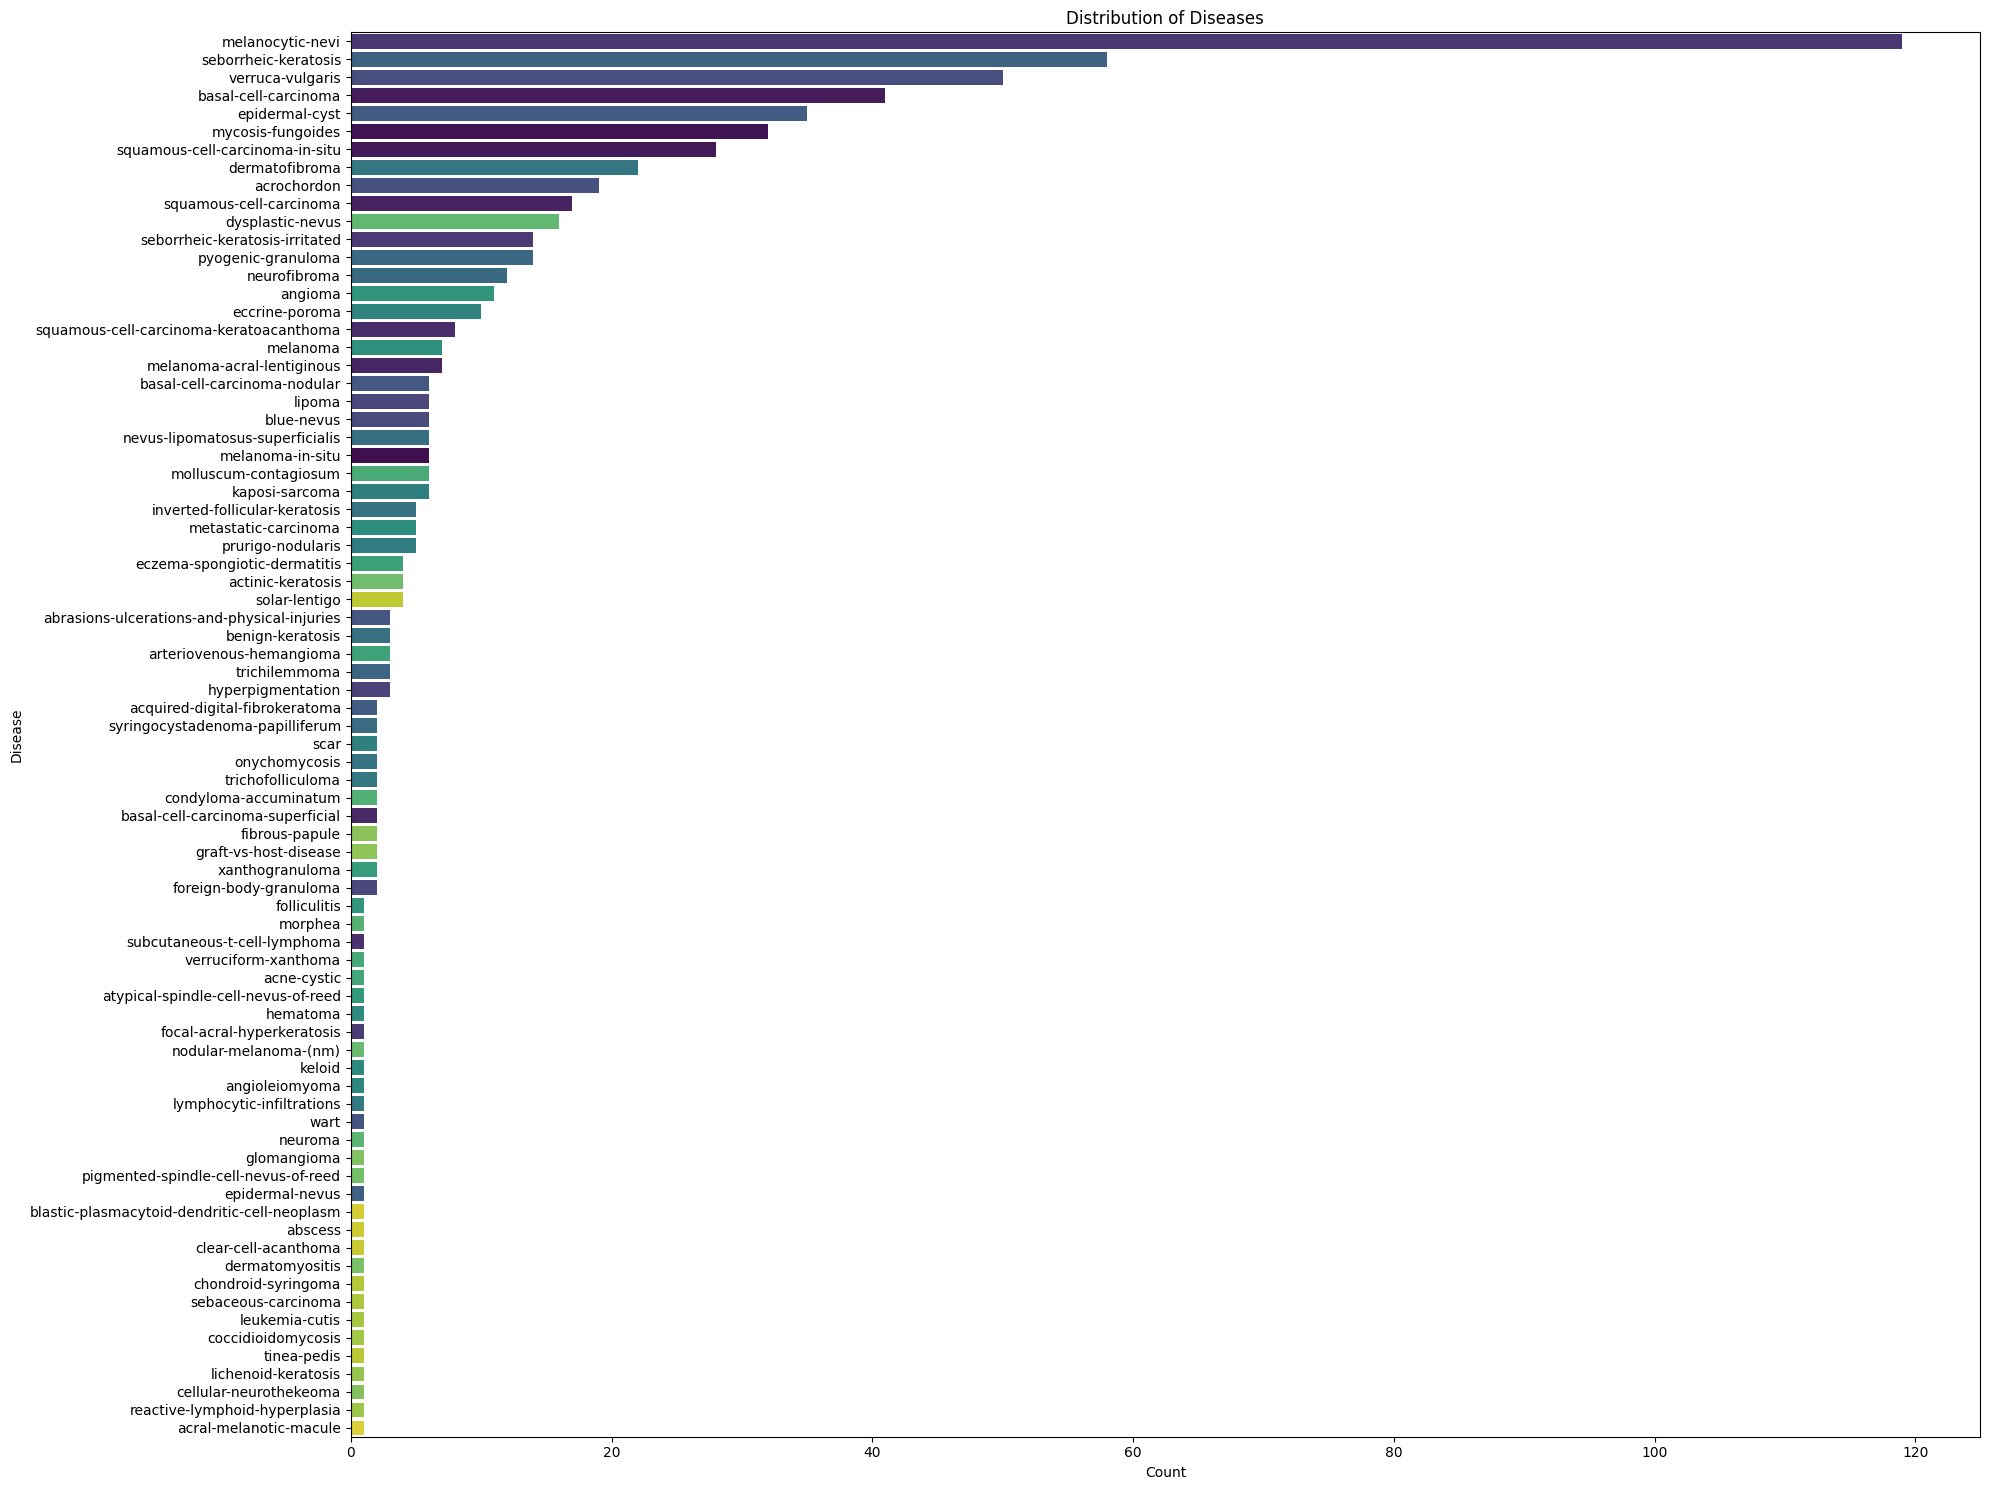

In [9]:
# Plotting 'Distribution of Diseases'
fig, ax = plt.subplots(figsize=(20, 15))
disease_counts = ddi_df['disease'].value_counts().sort_values(ascending=False)
sns.countplot(y='disease', data=ddi_df, ax=ax, palette='viridis', order=disease_counts.index, hue='disease', legend=False)

ax.set_title('Distribution of Diseases')
ax.set_xlabel('Count')
ax.set_ylabel('Disease')
plt.tight_layout()
plt.show()

#### Fitzpatrick skin types labels in the dataset: FST 12 - Fitzpatrick I-II, FST 34 - Fitzpatrick III-IV, FST 56 - Fitzpatrick V-VI

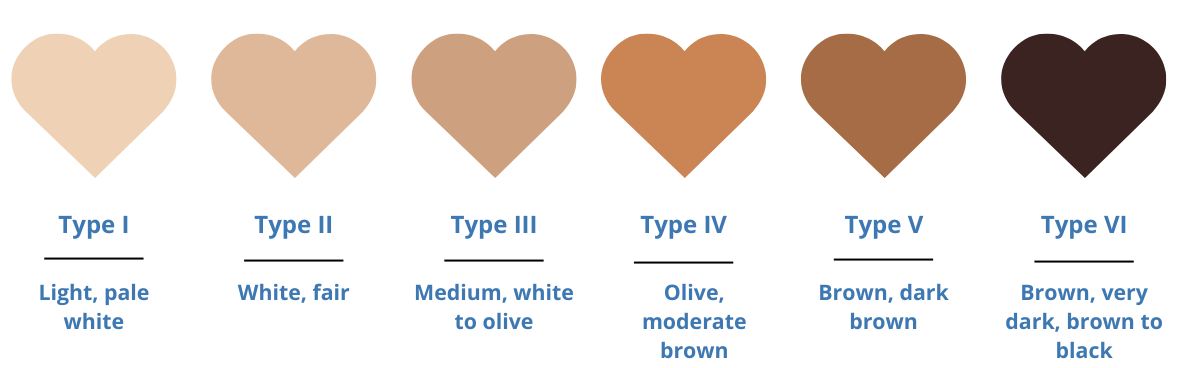

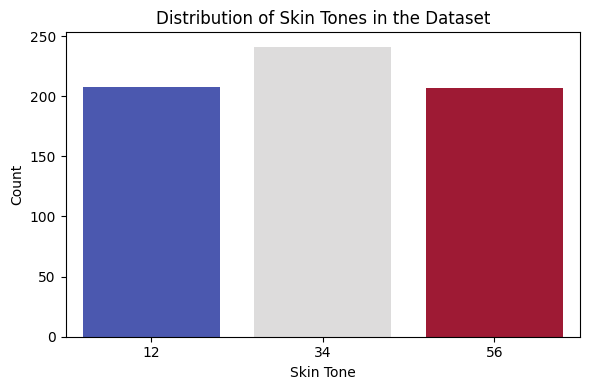

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='skin_tone', data=ddi_df, hue='skin_tone', ax=ax, palette='coolwarm', legend=False)

# Set the title and labels
ax.set_title('Distribution of Skin Tones in the Dataset')
ax.set_xlabel('Skin Tone')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

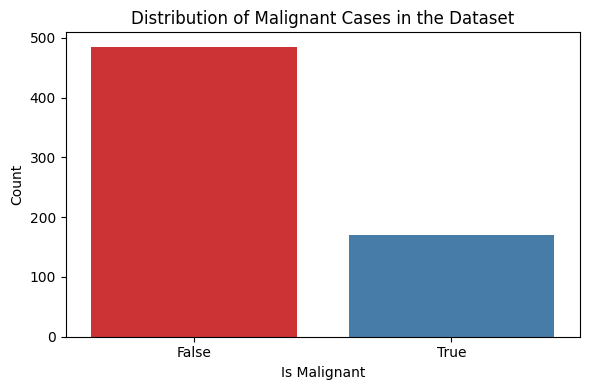

In [11]:
#Distribution of data in 'malignant' column
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='malignant', data=ddi_df, hue='malignant', ax=ax, palette='Set1', legend=False)
ax.set_title('Distribution of Malignant Cases in the Dataset')
ax.set_xlabel('Is Malignant')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

### As we can see the disctibution of malignant cases in the dataset is imbalanced

In [12]:
ddi_images = glob.glob('*.png')
len(ddi_images)

656

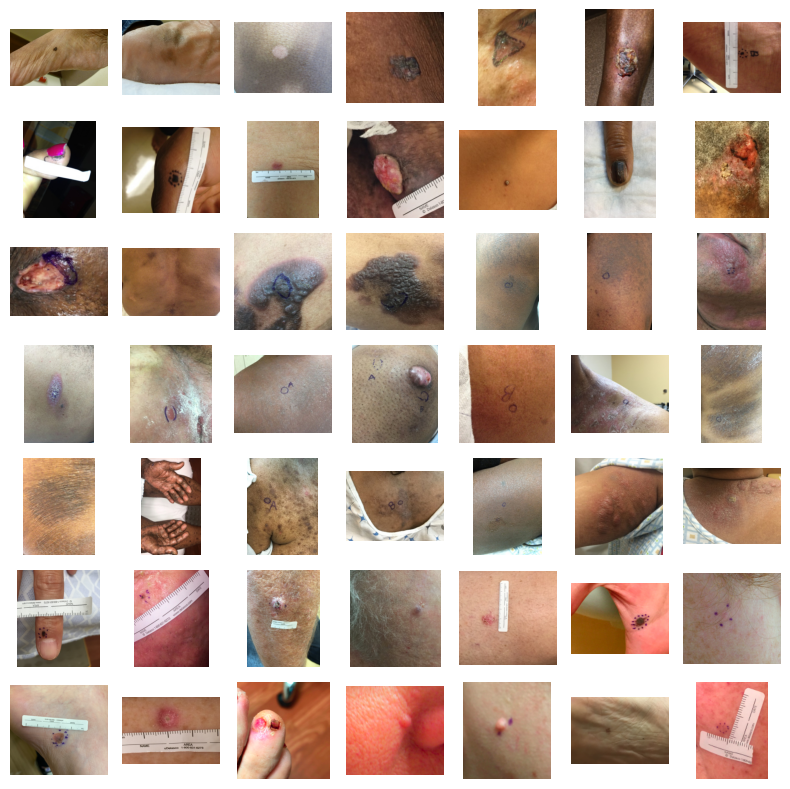

In [13]:
plt.figure(figsize=(8, 8))
nrows, ncols = 7, 7
max_imgs = nrows * ncols  # Maximum number of images you can display

# Only loop through the first 'max_imgs' images
for i, file in enumerate(ddi_images[:max_imgs]):
    img = skimage.io.imread(file)

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Step 1: Define a Custom Dataset Class
This class will handle loading and transforming images on-the-fly.

In [14]:
class CustomDDIDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.ddi_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.ddi_frame['malignant'] = self.ddi_frame['malignant'].astype(int)

    def __len__(self):
        return len(self.ddi_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.ddi_frame.iloc[idx]['DDI_file'])
        image = Image.open(img_name).convert('RGB')
        label = self.ddi_frame.iloc[idx]['malignant']
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

### Step 2: Initialize Dataset and DataLoader

In [ ]:
# Transformation with data augmentation for training
train_transform = T.Compose([

    T.Resize(299),  # Resize so the smallest side is 299 pixels
    T.RandomHorizontalFlip(),  # Randomly flip images horizontally
    T.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    T.RandomResizedCrop(299),  # Randomly crop and resize to 299x299
    T.ToTensor(),  # Convert image to a PyTorch tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Transformation without data augmentation for validation/testing
val_transform = T.Compose([
  
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the full dataset with transformations
full_dataset = CustomDDIDataset(csv_file='C:\\Users\\user\\DDI\\ddi_metadata.csv',
                                root_dir='C:\\Users\\user\\DDI\\images',
                                transform=train_transform)  # You might want to have a separate transform for full_dataset if necessary

# For training
train_dataset = CustomDDIDataset(csv_file='C:\\Users\\user\\DDI\\ddi_metadata.csv',
                                 root_dir='C:\\Users\\user\\DDI\\images',
                                 transform=train_transform)

# For validation/testing
val_dataset = CustomDDIDataset(csv_file='C:\\Users\\user\\DDI\\ddi_metadata.csv',
                               root_dir='C:\\Users\\user\\DDI\\images',
                               transform=val_transform)

### Handling Malignant/Benign Class Imbalancing for Binary Classification

The WeightedRandomSampler is used in PyTorch to handle class imbalance by providing a probability weight for each sample in the dataset. This way, samples from underrepresented classes are more likely to be included in each batch during training, which helps the model to learn from a more balanced representation of classes

#### A. Extracting the labels from the DataFrame and storing them as a numpy array:

In [43]:
#Extracting the labels from the DataFrame and storing them as a numpy array
labels = ddi_df['malignant'].values
# Assuming binary classification with labels 0 and 1
class_sample_count = torch.tensor([
    (labels == 0).sum(),  # Count of class 0
    (labels == 1).sum()   # Count of class 1
])

#### B. Calculating the count of each class in the dataset and storing it in a PyTorch tensor. This will be used to compute class weights, as it's common for datasets to have an uneven number of samples per class, which can lead to biased training if not handled properly.

In [46]:
#Computing class weights as the inverse of the class sample counts. 
#If a class has more samples, it gets a lower weight. 
#The weights are converted to float for correct division and to avoid integer division in Python.

class_weights = 1. / class_sample_count.float()

# Map each label in 'labels' to its corresponding weight
# If 'labels' is a numpy array:
samples_weights = np.array([class_weights[label].item() for label in labels])

# If 'labels' is a torch tensor:
samples_weights = torch.tensor([class_weights[label].item() for label in labels])

# Creating the WeightedRandomSampler with the computed sample weights
# This sampler will be used by a DataLoader to draw samples in a way that each class is represented equally, by sampling from the dataset according to the specified weights. 
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

C:\Users\user\AppData\Local\Temp\ipykernel_6456\1181466348.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  samples_weights = np.array([class_weights[label].item() for label in labels])
C:\Users\user\AppData\Local\Temp\ipykernel_6456\1181466348.py:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  samples_weights = torch.tensor([class_weights[label].item() for label in labels])


### Step 3 Split Your Dataset into Training, Validating and Testing

#### *** Note that train_loader includes uses the sampler (WeightedRandomSampler) we've just definced to ensure that each class is equally represented within each batch to deal with class imbalance.***

In [18]:
# Splitting the dataset into training, validation, and test sets
train_idx, val_test_idx = train_test_split(range(len(full_dataset)), test_size=0.4, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)

# Creating train, validation, and test subsets
train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)
test_subset = Subset(full_dataset, test_idx)

# Creating DataLoader instances for all subsets
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, shuffle=False) #THIS LINE WAS CHANGED
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

### Step 4: Define the Training Loop

In [33]:
def train_model(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=30, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        
        # Training phase
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        train_loss = running_loss / len(train_dataloader.dataset)
        train_acc = running_corrects.double() / len(train_dataloader.dataset)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_corrects = 0
        
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_loss / len(val_dataloader.dataset)
        val_acc = val_corrects.double() / len(val_dataloader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        # Checkpointing
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print('Validation loss decreased, saving model...')
        else:
            epochs_no_improve += 1
            print(f'Validation loss did not decrease, epochs with no improvement: {epochs_no_improve}.')
        
        if epochs_no_improve == patience:
            print('Early stopping triggered.')
            break
        
        scheduler.step()

    print('Training complete. Best val Loss: {:4f}'.format(best_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Now we will test different models for training

#### MobileNetV2 model

In [49]:
from torchvision import models
# Initialize the MobileNetV2 model with pre-trained weights
mobilenet_v2_model = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

# Modifying the classifier for binary classification
num_ftrs = mobilenet_v2_model.classifier[1].in_features
mobilenet_v2_model.classifier[1] = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2_model = mobilenet_v2_model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Call the updated train_model function with train and validation dataloaders
MobileNetV2_best_model = train_model(mobilenet_v2_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=15, patience=3)

Epoch 1/15
Train Loss: 0.6456 Acc: 0.6098
Validation Loss: 0.5374 Acc: 0.7328
Validation loss decreased, saving model...
Epoch 2/15
Train Loss: 0.5180 Acc: 0.7393
Validation Loss: 0.4652 Acc: 0.7557
Validation loss decreased, saving model...
Epoch 3/15
Train Loss: 0.5202 Acc: 0.7378
Validation Loss: 0.5751 Acc: 0.7557
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 4/15
Train Loss: 0.4718 Acc: 0.7698
Validation Loss: 0.4133 Acc: 0.8092
Validation loss decreased, saving model...
Epoch 5/15
Train Loss: 0.4214 Acc: 0.8155
Validation Loss: 0.3600 Acc: 0.8321
Validation loss decreased, saving model...
Epoch 6/15
Train Loss: 0.3755 Acc: 0.8262
Validation Loss: 0.3537 Acc: 0.8626
Validation loss decreased, saving model...
Epoch 7/15
Train Loss: 0.3764 Acc: 0.8293
Validation Loss: 0.3211 Acc: 0.8931
Validation loss decreased, saving model...
Epoch 8/15
Train Loss: 0.3491 Acc: 0.8582
Validation Loss: 0.2568 Acc: 0.8931
Validation loss decreased, saving model...
Epoch 9/15

### Let's evaluate the model performance

Accuracy: 0.9394
Precision: 0.8571
Recall: 0.9091
F1 Score: 0.8824
ROC AUC Score: 0.9706
Confusion Matrix:
 [[94  5]
 [ 3 30]]


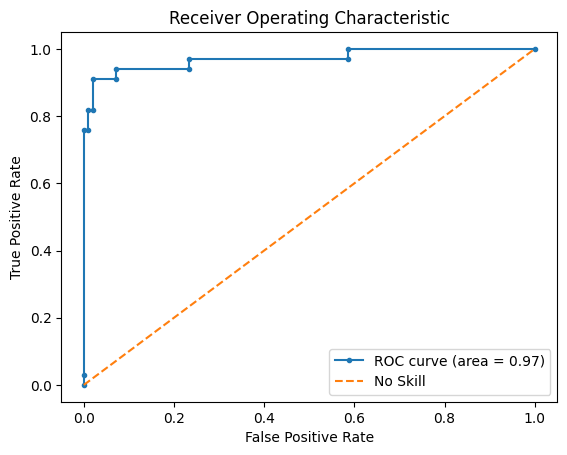

In [51]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    predictions = []
    pred_probs = []  # Store prediction probabilities for ROC AUC calculation
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # Assuming the model outputs logit scores, apply softmax to get probabilities
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Get the probability of the positive class
            
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
            pred_probs.extend(probs)  # Append probability of positive class
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc_score = roc_auc_score(true_labels, pred_probs)  # Calculate ROC AUC score
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {auc_score:.4f}')
    print('Confusion Matrix:\n', conf_matrix)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    plt.plot(fpr, tpr, marker='.', label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()

# Assuming your best_model is defined and test_dataloader is your validation/test dataloader
evaluate_model(MobileNetV2_best_model, test_loader, device)

### ResNet50 model

In [29]:
# Load the pre-trained ResNet50 model
resnet50_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Modify the final fully connected layer for binary classification
num_ftrs_resnet50 = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_ftrs_resnet50, 2)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
resnet50_model = resnet50_model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
# Call the updated train_model function with train and validation dataloaders
ResNet50_best_model = train_model(resnet50_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=15, patience=3)

Epoch 1/15
Train Loss: 0.6213 Acc: 0.6387
Validation Loss: 0.4279 Acc: 0.8092
Validation loss decreased, saving model...
Epoch 2/15
Train Loss: 0.4741 Acc: 0.7790
Validation Loss: 0.3652 Acc: 0.8397
Validation loss decreased, saving model...
Epoch 3/15
Train Loss: 0.3935 Acc: 0.8354
Validation Loss: 0.4333 Acc: 0.8550
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 4/15
Train Loss: 0.4165 Acc: 0.8277
Validation Loss: 0.3556 Acc: 0.8397
Validation loss decreased, saving model...
Epoch 5/15
Train Loss: 0.3259 Acc: 0.8582
Validation Loss: 0.3509 Acc: 0.8550
Validation loss decreased, saving model...
Epoch 6/15
Train Loss: 0.2890 Acc: 0.8780
Validation Loss: 0.2814 Acc: 0.8779
Validation loss decreased, saving model...
Epoch 7/15
Train Loss: 0.2925 Acc: 0.8796
Validation Loss: 0.1846 Acc: 0.9389
Validation loss decreased, saving model...
Epoch 8/15
Train Loss: 0.2905 Acc: 0.8811
Validation Loss: 0.1875 Acc: 0.9084
Validation loss did not decrease, epochs with no impr

Accuracy: 0.9394
Precision: 0.8788
Recall: 0.8788
F1 Score: 0.8788
ROC AUC Score: 0.9822
Confusion Matrix:
 [[95  4]
 [ 4 29]]


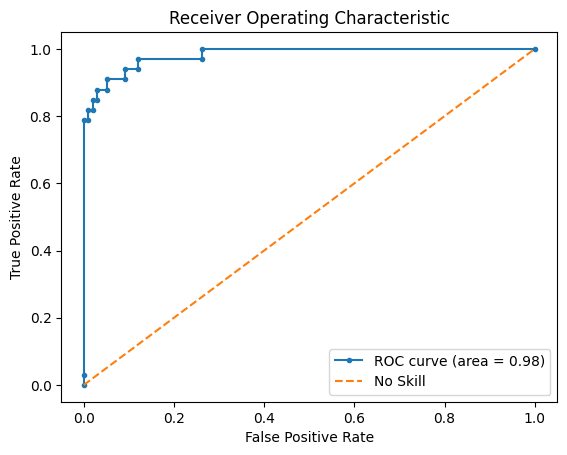

In [30]:
evaluate_model(ResNet50_best_model, test_loader, device)

### Inception3 model

In [31]:
# Load the pre-trained InceptionV3 model
inceptionv3_model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)

# Modify the final fully connected layer for binary classification
num_ftrs_inceptionv3 = inceptionv3_model.fc.in_features
inceptionv3_model.fc = nn.Linear(num_ftrs_inceptionv3, 2)

# Also modify the auxillary network's fully connected layer
num_ftrs_aux_inceptionv3 = inceptionv3_model.AuxLogits.fc.in_features
inceptionv3_model.AuxLogits.fc = nn.Linear(num_ftrs_aux_inceptionv3, 2)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
inceptionv3_model = inceptionv3_model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(inceptionv3_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

For the InceptionV3 model, we need to adjust the train_model function to account for the auxiliary output during the training phase. The auxiliary output is only used during training and should not be considered during evaluation.

In [32]:
def train_model_1(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=30, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        
        # Training phase
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            # Handle the outputs from the Inception model (main and aux outputs)
            if hasattr(model, 'aux_logits') and model.aux_logits:
                outputs, aux_outputs = model(inputs)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4*loss2  # Combine losses with auxiliary loss weighted
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            
            # Since we possibly have two losses, take the main loss for running loss
            running_loss += loss1.item() * inputs.size(0) if hasattr(model, 'aux_logits') and model.aux_logits else loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        train_loss = running_loss / len(train_dataloader.dataset)
        train_acc = running_corrects.double() / len(train_dataloader.dataset)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_corrects = 0
        
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_loss / len(val_dataloader.dataset)
        val_acc = val_corrects.double() / len(val_dataloader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        # Checkpointing
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print('Validation loss decreased, saving model...')
        else:
            epochs_no_improve += 1
            print(f'Validation loss did not decrease, epochs with no improvement: {epochs_no_improve}.')
        
        if epochs_no_improve == patience:
            print('Early stopping triggered.')
            break
        
        scheduler.step()  # Adjust the learning rate based on the number of epochs

    print('Training complete. Best val Loss: {:4f}'.format(best_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [33]:
# Call the updated train_model function with train and validation dataloaders
inceptionv3_best_model = train_model_1(inceptionv3_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=15, patience=3)

Epoch 1/15
Train Loss: 0.6335 Acc: 0.6159
Validation Loss: 0.5399 Acc: 0.7557
Validation loss decreased, saving model...
Epoch 2/15
Train Loss: 0.5293 Acc: 0.7439
Validation Loss: 0.4783 Acc: 0.7634
Validation loss decreased, saving model...
Epoch 3/15
Train Loss: 0.4605 Acc: 0.7973
Validation Loss: 0.3900 Acc: 0.8015
Validation loss decreased, saving model...
Epoch 4/15
Train Loss: 0.3903 Acc: 0.8262
Validation Loss: 0.3676 Acc: 0.8321
Validation loss decreased, saving model...
Epoch 5/15
Train Loss: 0.3364 Acc: 0.8491
Validation Loss: 0.2348 Acc: 0.9466
Validation loss decreased, saving model...
Epoch 6/15
Train Loss: 0.2998 Acc: 0.8720
Validation Loss: 0.2249 Acc: 0.9313
Validation loss decreased, saving model...
Epoch 7/15
Train Loss: 0.2372 Acc: 0.9085
Validation Loss: 0.1591 Acc: 0.9695
Validation loss decreased, saving model...
Epoch 8/15
Train Loss: 0.2234 Acc: 0.9070
Validation Loss: 0.1644 Acc: 0.9466
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 9/15

Accuracy: 0.8788
Precision: 0.7429
Recall: 0.7879
F1 Score: 0.7647
ROC AUC Score: 0.9568
Confusion Matrix:
 [[90  9]
 [ 7 26]]


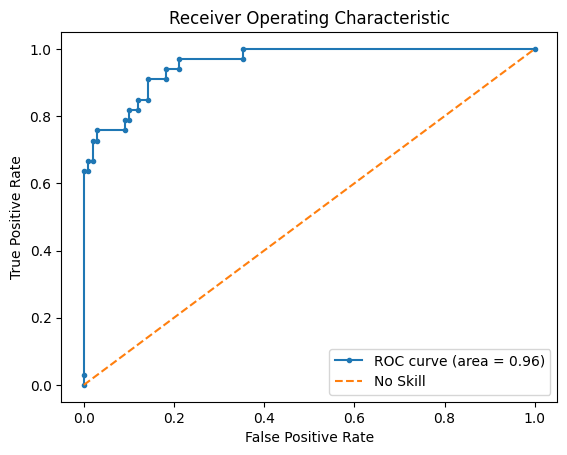

In [34]:
# Assuming your best_model is defined and test_dataloader is your validation/test dataloader
evaluate_model(inceptionv3_best_model, test_loader, device)

## VGG16 model

In [34]:
import torch.nn as nn
from torchvision import models
from torchvision.models import VGG16_Weights

# Load the VGG16 model with predefined weights
vgg16_model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# Get the input features of the last layer
num_ftrs_vgg16 = vgg16_model.classifier[6].in_features

# Replace the last layer with a new linear layer for binary classification
vgg16_model.classifier[6] = nn.Linear(num_ftrs_vgg16, 2)

In [36]:
# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_model = vgg16_model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(vgg16_model.parameters(), lr=0.0001)

# Optionally define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Assuming train_loader and val_loader are already defined
VGG16_best_model = train_model(vgg16_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=15, patience=3)

Epoch 1/15
Train Loss: 0.7064 Acc: 0.5442
Validation Loss: 0.7824 Acc: 0.3206
Validation loss decreased, saving model...
Epoch 2/15
Train Loss: 0.6862 Acc: 0.5671
Validation Loss: 0.5777 Acc: 0.7786
Validation loss decreased, saving model...
Epoch 3/15
Train Loss: 0.6318 Acc: 0.6448
Validation Loss: 0.6105 Acc: 0.6718
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 4/15
Train Loss: 0.6142 Acc: 0.6585
Validation Loss: 0.7200 Acc: 0.4962
Validation loss did not decrease, epochs with no improvement: 2.
Epoch 5/15
Train Loss: 0.6021 Acc: 0.6875
Validation Loss: 0.4913 Acc: 0.8015
Validation loss decreased, saving model...
Epoch 6/15
Train Loss: 0.5884 Acc: 0.6951
Validation Loss: 0.5334 Acc: 0.7557
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 7/15
Train Loss: 0.6140 Acc: 0.6936
Validation Loss: 0.5419 Acc: 0.7176
Validation loss did not decrease, epochs with no improvement: 2.
Epoch 8/15
Train Loss: 0.5704 Acc: 0.7210
Validation Loss: 0.5666

In [38]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    predictions = []
    pred_probs = []  # Store prediction probabilities for ROC AUC calculation
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # Assuming the model outputs logit scores, apply softmax to get probabilities
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Get the probability of the positive class
            
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
            pred_probs.extend(probs)  # Append probability of positive class
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc_score = roc_auc_score(true_labels, pred_probs)  # Calculate ROC AUC score
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {auc_score:.4f}')
    print('Confusion Matrix:\n', conf_matrix)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    plt.plot(fpr, tpr, marker='.', label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()

Accuracy: 0.8333
Precision: 0.7895
Recall: 0.4545
F1 Score: 0.5769
ROC AUC Score: 0.7511
Confusion Matrix:
 [[95  4]
 [18 15]]


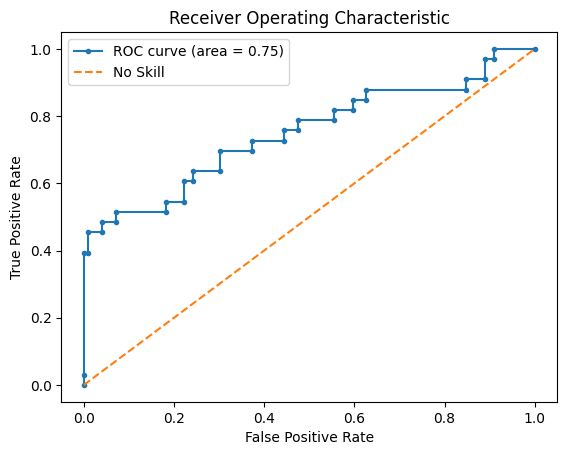

In [39]:
evaluate_model(VGG16_best_model, test_loader, device)

## MobileNet_V3_Large_Weights

In [52]:
# Initialize the MobileNetV3-Large model with pre-trained weights
mobilenet_v3_large_model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)

# Modifying the classifier for binary classification
# MobileNetV3-Large uses 'classifier' instead of 'fc' for its final fully connected layer
num_ftrs = mobilenet_v3_large_model.classifier[-1].in_features
mobilenet_v3_large_model.classifier[-1] = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v3_large_model = mobilenet_v3_large_model.to(device)

# Setup the loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v3_large_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Assuming train_model function, train_loader, and val_loader are defined as per your earlier code
MobileNetV3_best_model = train_model(mobilenet_v3_large_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=15, patience=3)

Epoch 1/15
Train Loss: 0.6503 Acc: 0.6311
Validation Loss: 0.5843 Acc: 0.7405
Validation loss decreased, saving model...
Epoch 2/15
Train Loss: 0.5706 Acc: 0.7134
Validation Loss: 0.5251 Acc: 0.7252
Validation loss decreased, saving model...
Epoch 3/15
Train Loss: 0.5199 Acc: 0.7500
Validation Loss: 0.4823 Acc: 0.7481
Validation loss decreased, saving model...
Epoch 4/15
Train Loss: 0.4613 Acc: 0.7790
Validation Loss: 0.5271 Acc: 0.7481
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 5/15
Train Loss: 0.4013 Acc: 0.8232
Validation Loss: 0.4254 Acc: 0.7863
Validation loss decreased, saving model...
Epoch 6/15
Train Loss: 0.3733 Acc: 0.8476
Validation Loss: 0.4828 Acc: 0.7710
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 7/15
Train Loss: 0.3673 Acc: 0.8476
Validation Loss: 0.3573 Acc: 0.8626
Validation loss decreased, saving model...
Epoch 8/15
Train Loss: 0.3389 Acc: 0.8262
Validation Loss: 0.3767 Acc: 0.8397
Validation loss did not decreas

Accuracy: 0.9015
Precision: 0.8125
Recall: 0.7879
F1 Score: 0.8000
ROC AUC Score: 0.9617
Confusion Matrix:
 [[93  6]
 [ 7 26]]


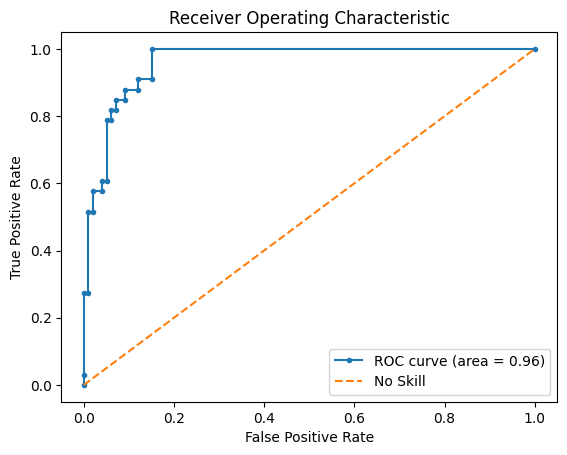

In [53]:
evaluate_model(MobileNetV3_best_model, test_loader, device)

## Xception model

In [54]:
# Create the Xception model with pre-trained weights using the updated model name
xception_model = timm.create_model('legacy_xception', pretrained=True)

# Modify the classifier for binary classification
num_ftrs = xception_model.fc.in_features
xception_model.fc = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xception_model = xception_model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xception_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Xception_best_model = train_model(xception_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=15, patience=3)

Epoch 1/15
Train Loss: 0.6555 Acc: 0.5747
Validation Loss: 0.6317 Acc: 0.6412
Validation loss decreased, saving model...
Epoch 2/15
Train Loss: 0.5843 Acc: 0.6997
Validation Loss: 0.6098 Acc: 0.6641
Validation loss decreased, saving model...
Epoch 3/15
Train Loss: 0.4956 Acc: 0.7652
Validation Loss: 0.4147 Acc: 0.8015
Validation loss decreased, saving model...
Epoch 4/15
Train Loss: 0.3964 Acc: 0.8354
Validation Loss: 0.3106 Acc: 0.8779
Validation loss decreased, saving model...
Epoch 5/15
Train Loss: 0.3179 Acc: 0.8613
Validation Loss: 0.2262 Acc: 0.9084
Validation loss decreased, saving model...
Epoch 6/15
Train Loss: 0.2697 Acc: 0.8902
Validation Loss: 0.2010 Acc: 0.9237
Validation loss decreased, saving model...
Epoch 7/15
Train Loss: 0.2194 Acc: 0.9116
Validation Loss: 0.1684 Acc: 0.9160
Validation loss decreased, saving model...
Epoch 8/15
Train Loss: 0.1908 Acc: 0.9253
Validation Loss: 0.1527 Acc: 0.9618
Validation loss decreased, saving model...
Epoch 9/15
Train Loss: 0.2212 Ac

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    predictions = []
    pred_probs = []  # Store prediction probabilities for ROC AUC calculation
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # Assuming the model outputs logit scores, apply softmax to get probabilities
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Get the probability of the positive class
            
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
            pred_probs.extend(probs)  # Append probability of positive class
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc_score = roc_auc_score(true_labels, pred_probs)  # Calculate ROC AUC score
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {auc_score:.4f}')
    print('Confusion Matrix:\n', conf_matrix)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    plt.plot(fpr, tpr, marker='.', label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()

Accuracy: 0.9470
Precision: 0.8611
Recall: 0.9394
F1 Score: 0.8986
ROC AUC Score: 0.9740
Confusion Matrix:
 [[94  5]
 [ 2 31]]


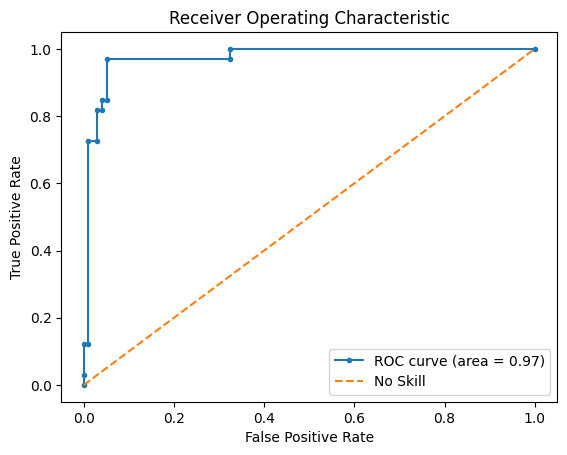

In [56]:
evaluate_model(Xception_best_model, test_loader, device)

## AlexNet Model

In [40]:
# Initialize the AlexNet model with pre-trained weights
alexnet_model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

# Modifying the classifier for binary classification
# AlexNet's classifier has 6 layers, with the last one being the output layer.
num_ftrs = alexnet_model.classifier[6].in_features
alexnet_model.classifier[6] = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_model = alexnet_model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [41]:
AlexNet_best_model = train_model(alexnet_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=15, patience=3)

Epoch 1/15
Train Loss: 0.6680 Acc: 0.5899
Validation Loss: 0.5583 Acc: 0.7252
Validation loss decreased, saving model...
Epoch 2/15
Train Loss: 0.5822 Acc: 0.7012
Validation Loss: 0.5994 Acc: 0.7099
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 3/15
Train Loss: 0.5096 Acc: 0.7668
Validation Loss: 0.4274 Acc: 0.7863
Validation loss decreased, saving model...
Epoch 4/15
Train Loss: 0.5105 Acc: 0.7561
Validation Loss: 0.6688 Acc: 0.6183
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 5/15
Train Loss: 0.4955 Acc: 0.7515
Validation Loss: 0.4212 Acc: 0.8168
Validation loss decreased, saving model...
Epoch 6/15
Train Loss: 0.4803 Acc: 0.7652
Validation Loss: 0.3785 Acc: 0.8931
Validation loss decreased, saving model...
Epoch 7/15
Train Loss: 0.4444 Acc: 0.7820
Validation Loss: 0.4363 Acc: 0.8397
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 8/15
Train Loss: 0.3893 Acc: 0.8277
Validation Loss: 0.4007 Acc: 0.8473
Validatio

Accuracy: 0.8409
Precision: 0.6429
Recall: 0.8182
F1 Score: 0.7200
ROC AUC Score: 0.9011
Confusion Matrix:
 [[84 15]
 [ 6 27]]


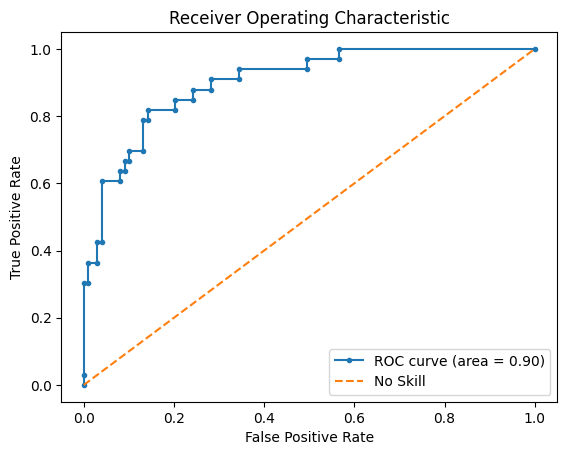

In [42]:
evaluate_model(AlexNet_best_model, test_loader, device)

#### Checking results

In [48]:
def imshow(inp, ax, title=None):
    """Imshow for Tensor on a given axes object."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

def display_images_with_confidence(model, data_loader, class_names, num_images=4):
    model.eval()  # Set model to evaluation mode
    images_handled = 0
    
    # Calculate the number of rows and columns for the subplots
    num_rows = 1
    num_cols = num_images
    
    # Set up the subplot grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    if num_images == 1:
        axes = [axes]
    
    with torch.no_grad():  # Inference without gradient calculation
        for images, labels in data_loader:
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            confidences, preds = torch.max(probabilities, 1)
            
            # Move images, labels, and confidences to CPU
            images = images.cpu()
            labels = labels.cpu()
            preds = preds.cpu()
            confidences = confidences.cpu()
            
            for i in range(images.size()[0]):
                if images_handled >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                
                ax = axes[images_handled]
                confidence_pct = confidences[i].item() * 100
                imshow(images[i], ax, title=f'Predicted: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}\nConfidence: {confidence_pct:.2f}%')
                
                images_handled += 1

    plt.tight_layout()
    plt.show()

### Now we can visualize the accuracy for images with the class of skin leason

In [49]:
class_names = ['Benign', 'Malignant']
display_images_with_confidence(Xception_best_model, test_loader, class_names, num_images=9)   ### Chose the required model

NameError: name 'Xception_best_model' is not defined

 settings.